In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("darkgrid")
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

from scipy.stats import shapiro 
from scipy.stats import pearsonr

In [2]:
DATA_DIR = "../data"
DATA_PROCESSED =  DATA_DIR + "/processed"
PROCESSED_CONT_PATH = f"{DATA_PROCESSED}/cont.csv"
PROCESSED_MET_PATH = f"{DATA_PROCESSED}/meteo.csv"

PROCESSED_CONT_PATH_W_FLAG = f"{DATA_PROCESSED}/cont_flags.csv"
PROCESSED_MET_PATH_W_FLAG = f"{DATA_PROCESSED}/meteo_flags.csv"

PROCESSED_PIV_CONT_PATH = f"{DATA_PROCESSED}/piv_cont.csv"
PROCESSED_PIV_MET_PATH = f"{DATA_PROCESSED}/piv_meteo.csv"

In [3]:
def calculate_pvalues(df):
    cols = df.drop('date', axis=1).columns
    p_values = []
    for i in cols:
        for j in cols:
            _, p_val = pearsonr(df[i], df[j])
            p_values.append(p_val)


    p_values = np.array(p_values).reshape(len(cols), len(cols))
    return pd.DataFrame(p_values)

# Contaminantes

## Explorar patrón en banderas

DF incluyendo filas con banderas invalidas

In [4]:
cont_flags = pd.read_csv(PROCESSED_CONT_PATH)
cont_flags.head()

date parameter  Value Flag
0  2021-07-01 00:00:00      PM10    NaN    x
1  2021-07-01 00:00:00     PM2.5    NaN    x
2  2021-07-01 00:00:00        O3    NaN    x
3  2021-07-01 00:00:00       SO2    NaN    x
4  2021-07-01 00:00:00       NO2    NaN    e

In [5]:
cont_flags['invalid'] = cont_flags['Value'].isna().astype('int')

Extrar la hora y dia de los registros con banderas

In [6]:
cont_flags['date'] = pd.to_datetime(cont_flags['date'])
cont_flags['hour'] = cont_flags['date'].apply(lambda x: x.hour)
cont_flags['weekday'] = cont_flags['date'].apply(lambda x: x.weekday())

Agrupar por hora, boolean invalido, y el tipo de bandera. Tomar los registros con bandera invalida y graficar en histograma categorizado por el tipo de bandera. 

In [7]:
flags_per_hour = cont_flags.groupby(['hour', 'invalid', 'Flag']).count().reset_index()[['hour', 'invalid', 'Flag', 'parameter']]
flags_per_hour = flags_per_hour[flags_per_hour['invalid'] == 1]
flags_per_hour
px.histogram(flags_per_hour, x = 'hour', y='parameter', color='Flag', nbins=24)

Agrupar por dia, tomar los registros con bandera invalida y graficar en histograma

In [8]:
flags_per_hour = cont_flags.groupby(['weekday', 'invalid', 'Flag']).count().reset_index()[['weekday', 'invalid', 'Flag', 'parameter']]
flags_per_hour = flags_per_hour[flags_per_hour['invalid'] == 1]
flags_per_hour
px.histogram(flags_per_hour, x = 'weekday', y='parameter', color='Flag', nbins=24)

## Exploración

Explorar df pivoteada

In [9]:
cont = pd.read_csv(PROCESSED_PIV_CONT_PATH)
cont.head()

date    CO   NO2    O3  PM10  PM2.5  SO2
0  2021-07-01 00:00:00   NaN   NaN   NaN   NaN    NaN  NaN
1  2021-07-01 01:00:00  0.49   3.9  22.0  21.0    NaN  2.8
2  2021-07-01 02:00:00  0.51   8.4  17.0  24.0    3.0  3.1
3  2021-07-01 03:00:00  0.50   6.4  19.0  22.0    5.0  3.0
4  2021-07-01 04:00:00  0.51  10.0  14.0  35.0   15.0  3.2

In [52]:
cont.describe()

CO          NO2           O3         PM10        PM2.5  \
count  9946.000000  9946.000000  9946.000000  9946.000000  9946.000000   
mean      1.416136    16.010296    27.693947    65.049769    17.763221   
std       0.590289    10.064219    20.285257    40.166226    10.061477   
min       0.240000     1.900000     1.000000     6.000000     2.000000   
25%       0.900000     8.600000    12.000000    41.000000    10.000000   
50%       1.290000    14.300000    24.000000    58.000000    16.000000   
75%       1.920000    20.799999    38.000000    79.000000    23.000000   
max       4.740000    75.900002   136.000000   746.000000   105.000000   

               SO2  
count  9946.000000  
mean      5.154424  
std       2.824377  
min       2.100000  
25%       3.800000  
50%       4.400000  
75%       5.600000  
max      83.800003

In [55]:
cont.median(numeric_only=True)

CO        1.29
NO2      14.30
O3       24.00
PM10     58.00
PM2.5    16.00
SO2       4.40
dtype: float64

* No existen valores negativos, i.e. No hay errores por ese lado.

In [11]:
cont.describe().loc['min']

CO       0.24
NO2      0.30
O3       1.00
PM10     5.00
PM2.5    2.00
SO2      1.50
Name: min, dtype: float64

### Exploración de variables númericas usando visualización

#### Medidas de posición no central

In [12]:
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
cont_cols = cont.select_dtypes(include=numerics).columns
cont_units = {'PM10':'µg/m^3', 'PM2.5': 'µg/m^3', 'O3':'ppb', 'SO2':'ppb', 'NO2':'ppb', 'CO':'ppm', 'NO':'ppb'}
rows, cols= [1,1,1,2,2,2], [1,2,3,1,2,3]
fig = make_subplots(rows=2, cols=3, subplot_titles=cont_cols)

for i, col in enumerate(cont_cols):
    fig.add_trace(go.Box(x = [col]*len(cont), y = cont[col], name=cont_units[col]),
                    row=rows[i], col=cols[i])

fig.update_layout(title='Contaminantes', height=600, width=900)
fig.show()

#### Análisis de Distribución

In [13]:
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
cont_cols = cont.select_dtypes(include=numerics).columns
cont_units = {'PM10':'µg/m^3', 'PM2.5': 'µg/m^3', 'O3':'ppb', 'SO2':'ppb', 'NO2':'ppb', 'CO':'ppm', 'NO':'ppb'}
rows, cols= [1,1,2,2,3,3], [1,2,1,2,1,2]
fig = make_subplots(rows=3, cols=2, subplot_titles=cont_cols)

for i, col in enumerate(cont_cols):

    fig.add_trace(go.Histogram(x = cont[col], name=cont_units[col]),
                    row=rows[i], col=cols[i])

fig.update_layout(title='Contaminantes', height=600, width=900)
fig.show()

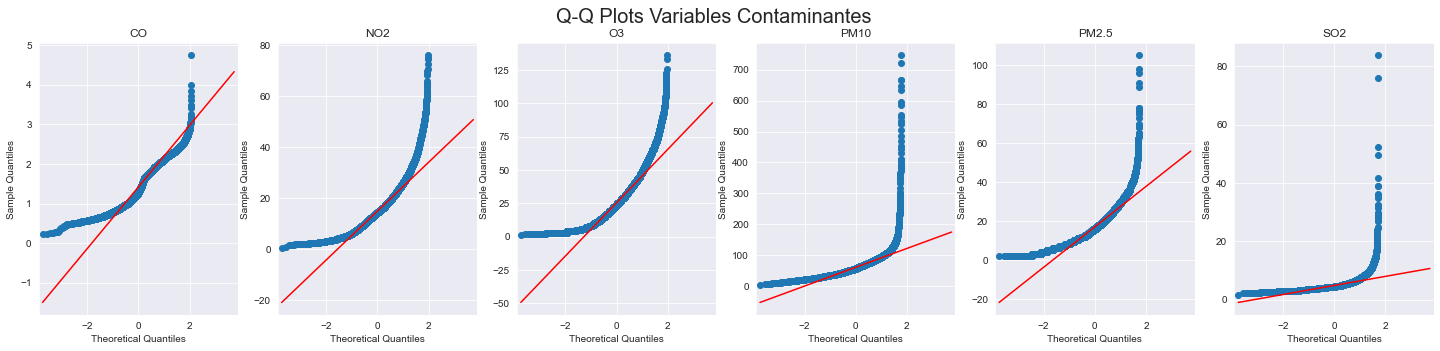

In [14]:
import statsmodels.api as sm

fig, axs = plt.subplots(1, 6, figsize=(25,5))
fig.suptitle('Q-Q Plots Variables Contaminantes', fontsize=20)

for i, col in enumerate(cont_cols):
    sm.qqplot(cont[col], line='q', ax=axs[i])
    axs[i].set_title(col)

#### Análisis de Correlación

In [15]:
cont = cont.dropna()

In [16]:
fig = px.imshow(cont.corr(method='pearson').round(2), color_continuous_scale='ice', title='Mapa Correlación', text_auto=True)

fig.layout.height = 500
fig.layout.width = 500

fig.show()

Significancia de correlaciones

In [17]:
p_values = calculate_pvalues(cont)

fig = px.imshow(p_values.round(2), color_continuous_scale='ice', title='Mapa Correlación', text_auto=True)
fig.layout.height = 500
fig.layout.width = 500
fig.show()

### Valores Faltantes

In [18]:
print(cont.isna().sum())
print(f"Total faltantes: {cont.isna().sum().sum()}")

date     0
CO       0
NO2      0
O3       0
PM10     0
PM2.5    0
SO2      0
dtype: int64
Total faltantes: 0


In [19]:
# N. filas con valores faltantes e invalidos
tmp = cont.isna().sum(axis=1).astype('bool').sum() 
print(f"Filas con valores faltantes: {tmp}")
# Proporción de filas con valores faltantes e invalidos
tmp / len(cont)

Filas con valores faltantes: 0


0.0

## Limpieza

Checar duplicados: No existe filas duplicadas

In [20]:
cont[cont.duplicated()]

Empty DataFrame
Columns: [date, CO, NO2, O3, PM10, PM2.5, SO2]
Index: []

# Meteorologica

### Leer df no pivoteada

In [21]:
met = pd.read_csv(PROCESSED_MET_PATH)
met.head()

date parameter  Value Flag
0  2021-07-01 00:00:00      TOUT    NaN    x
1  2021-07-01 00:00:00        RH    NaN    x
2  2021-07-01 00:00:00        SR    NaN    l
3  2021-07-01 00:00:00       PRS    NaN    x
4  2021-07-01 00:00:00     RAINF    NaN    x

Explorar datos negativos

In [22]:
tmp = met[met['Value'] < 0]
print(f"N. filas con valores negativos: {len(tmp)}")
tmp

N. filas con valores negativos: 43


date parameter  Value Flag
19364  2021-10-24 06:00:00        SR -0.002     
21716  2021-11-07 06:00:00        SR -0.002     
27596  2021-12-12 06:00:00        SR -0.002     
28772  2021-12-19 06:00:00        SR -0.002     
32293  2022-01-09 05:00:00        SR -0.002     
34651  2022-01-23 06:00:00        SR -0.002     
35820  2022-01-30 05:00:00        SR -0.002     
36658  2022-02-04 05:00:00      TOUT -0.110     
36665  2022-02-04 06:00:00      TOUT -0.240     
36672  2022-02-04 07:00:00      TOUT -0.530     
36679  2022-02-04 08:00:00      TOUT -0.320     
36996  2022-02-06 05:00:00        SR -0.002     
38172  2022-02-13 05:00:00        SR -0.002     
39348  2022-02-20 05:00:00        SR -0.002     
43989  2022-03-20 05:00:00        SR -0.002     
45165  2022-03-27 05:00:00        SR -0.002     
47524  2022-04-10 06:00:00        SR -0.002     
47650  2022-04-11 00:00:00        SR -0.002     
47657  2022-04-11 01:00:00        SR -0.002     
47664  2022-04-11 02:00:00        SR -0.002     
47671  2022-04-11 03:00:00        SR -0.002     
47678  2022-04-11 04:00:00        SR -0.002     
47685  2022-04-11 05:00:00        SR -0.002     
47692  2022-04-11 06:00:00        SR -0.002     
48700  2022-04-17 06:00:00        SR -0.002     
50849  2022-04-30 01:00:00        SR -0.002     
56925  2022-06-05 05:00:00        SR -0.002     
58108  2022-06-12 06:00:00        SR -0.001     
59283  2022-06-19 06:00:00        SR -0.001     
60459  2022-06-26 06:00:00        SR -0.001     
61627  2022-07-03 05:00:00        SR -0.002     
61634  2022-07-03 06:00:00        SR -0.001     
62803  2022-07-10 05:00:00        SR -0.002     
62810  2022-07-10 06:00:00        SR -0.002     
63979  2022-07-17 05:00:00        SR -0.002     
63986  2022-07-17 06:00:00        SR -0.002     
65162  2022-07-24 06:00:00        SR -0.002     
66338  2022-07-31 06:00:00        SR -0.002     
67514  2022-08-07 06:00:00        SR -0.002     
68683  2022-08-14 05:00:00        SR -0.002     
69866  2022-08-21 06:00:00        SR -0.002     
71035  2022-08-28 05:00:00        SR -0.002     
72211  2022-09-04 05:00:00        SR -0.002

#### Leer DF pivoteada

In [58]:
met = pd.read_csv(PROCESSED_PIV_MET_PATH)
met.head()

date        PRS  RAINF    RH  SR   TOUT   WDR    WSR
0  2021-07-01 00:00:00        NaN    NaN   NaN NaN    NaN   NaN    NaN
1  2021-07-01 01:00:00  714.50000    0.0  77.0 NaN  22.32  79.0  109.7
2  2021-07-01 02:00:00  714.20001    0.0  77.0 NaN  22.50  74.0  109.7
3  2021-07-01 03:00:00  714.20001    0.0  76.0 NaN  22.58  69.0  106.9
4  2021-07-01 04:00:00  714.20001    0.0  79.0 NaN  22.24  81.0  118.4

In [59]:
met.describe()

PRS         RAINF            RH           SR          TOUT  \
count  10745.000000  10748.000000  10726.000000  5807.000000  10745.000000   
mean     713.972656      0.002745     52.202965     0.345182     23.761760   
std        1.438916      0.038712     18.725830     0.264656      6.841511   
min      709.099980      0.000000      1.000000    -0.002000     -0.530000   
25%      713.099980      0.000000     38.000000     0.095000     20.030001   
50%      713.900020      0.000000     53.000000     0.317000     24.620001   
75%      714.799990      0.000000     67.000000     0.570000     28.549999   
max      719.599980      1.580000     88.000000     0.904000     41.310001   

                WDR           WSR  
count  10255.000000  10691.000000  
mean     111.173769     17.791049  
std       62.698436     22.820436  
min        2.000000      1.600000  
25%       71.000000      7.700000  
50%       87.000000     12.500000  
75%      118.000000     17.100000  
max      360.000000    227.100010

In [60]:
met.median(numeric_only=True)

PRS      713.900020
RAINF      0.000000
RH        53.000000
SR         0.317000
TOUT      24.620001
WDR       87.000000
WSR       12.500000
dtype: float64

### Exploración

#### Medidas de posición no central

In [25]:
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
met_cols = met.select_dtypes(include=numerics).columns
met_units = {'TOUT':'°C', 'RAINF':'mm/Hr', 'RH':'%', 'SR':'kW/m^2', 'PRS':'mm/Hg', 'WSR':'Km/hr', 'WDR': '°' }
rows, cols= [1,1,1,1, 2,2,2,2], [1,2,3,4,1,2,3]
fig = make_subplots(rows=2, cols=4)

for i, col in enumerate(met_cols):
    fig.add_trace(go.Box(x = [col]*len(cont), y = met[col], name=met_units[col]),
                    row=rows[i], col=cols[i])

fig.update_layout(title='Variables Meterológicas', height=600, width=900)

fig.show()

#### Análisis de Distribución

In [26]:
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
met_cols = met.select_dtypes(include=numerics).columns
met_units = {'TOUT':'°C', 'RAINF':'mm/Hr', 'RH':'%', 'SR':'kW/m^2', 'PRS':'mm/Hg', 'WSR':'Km/hr', 'WDR': '°' }
rows, cols= [1,1,1,1, 2,2,2,2], [1,2,3,4,1,2,3]
fig = make_subplots(rows=2, cols=4, subplot_titles=met_cols)

for i, col in enumerate(met_cols):

    fig.add_trace(go.Histogram(x = met[col], name=met_units[col]),
                    row=rows[i], col=cols[i])

fig.update_layout(title='Variables Meterológicas', height=600, width=900)

fig.show()

#### Análisis de Correlación

In [27]:
met = met.dropna()

In [28]:
fig = px.imshow(met.corr(method='pearson').round(2), color_continuous_scale='ice', title='Mapa Correlación', text_auto=True)

fig.layout.height = 500
fig.layout.width = 500

fig.show()

Significancia de correlaciones

In [29]:
p_values = calculate_pvalues(met)

fig = px.imshow(p_values.round(2), color_continuous_scale='ice', title='Mapa Correlación', text_auto=True)
fig.layout.height = 500
fig.layout.width = 500
fig.show()

### Valores faltantes

In [30]:
print(met.isna().sum())
print(f"Total faltantes: {met.isna().sum().sum()}")

date     0
PRS      0
RAINF    0
RH       0
SR       0
TOUT     0
WDR      0
WSR      0
dtype: int64
Total faltantes: 0


In [31]:
# N. filas con valores faltantes
tmp = met.isna().sum(axis=1).astype('bool').sum() 
print(f"Filas con valores faltantes: {tmp}")
# Proporción de filas con valores faltantes
tmp / len(met)

Filas con valores faltantes: 0


0.0

### Limpieza

Checar duplicados: No existen filas duplicadas

In [32]:
met[met.duplicated()]

Empty DataFrame
Columns: [date, PRS, RAINF, RH, SR, TOUT, WDR, WSR]
Index: []

# Ambas

In [33]:
merged = pd.merge(cont, met)
merged.head()

date    CO   NO2    O3  PM10  PM2.5  SO2        PRS  RAINF  \
0  2021-07-01 07:00:00  0.64  10.3  11.0  32.0    4.0  2.7  714.40002    0.0   
1  2021-07-01 08:00:00  0.73  11.7  12.0  23.0    6.0  2.9  714.59998    0.0   
2  2021-07-01 09:00:00  0.76  11.4  14.0  25.0    5.0  3.0  714.59998    0.0   
3  2021-07-01 10:00:00  0.74  11.2  17.0  34.0    3.0  3.0  714.50000    0.0   
4  2021-07-01 12:00:00  0.68  14.1  23.0  42.0   11.0  5.1  714.40002    0.0   

     RH     SR       TOUT   WDR         WSR  
0  81.0  0.034  22.270000  99.0  122.800000  
1  76.0  0.199  23.330000  66.0   90.400002  
2  72.0  0.322  24.040001  58.0   75.000000  
3  69.0  0.404  24.709999  54.0   65.000000  
4  65.0  0.475  26.049999  54.0   52.799999

In [34]:
fig = px.imshow(merged.corr(method='pearson').iloc[0:6, 6:].round(2), color_continuous_scale='ice', title='Mapa Correlación', text_auto=True)

fig.layout.height = 500
fig.layout.width = 500
fig.show()

Significancia de correlaciones

In [35]:
p_values = calculate_pvalues(merged).iloc[0:6, 6:]
fig = px.imshow(p_values.round(2), color_continuous_scale='ice', title='Mapa Correlación', text_auto=True)
fig.layout.height = 500
fig.layout.width = 500
fig.show()

In [37]:
import numpy as np
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
X = np.array([[-1, -1], [-2, -1], [-3, -2], [1, 1], [2, 1], [3, 2]])
y = np.array([1, 1, 1, 2, 2, 2])
clf = LinearDiscriminantAnalysis()
clf.fit(X, y)
print(clf.predict([[-0.8, -1]]))

[1]


In [49]:
tmp = pd.DataFrame(X)
tmp['class'] = y

In [50]:
tmp

0  1  class
0 -1 -1      1
1 -2 -1      1
2 -3 -2      1
3  1  1      2
4  2  1      2
5  3  2      2

In [51]:
px.scatter(tmp, color='class')